# 1141ML Final - DSM 2D - Small Pic

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn


transform = transforms.Compose([
    transforms.ToTensor(),          # shape: (1, 28, 28)
    transforms.Lambda(lambda x: x*2 - 1)  # scale to [-1, 1]
])

dataset = datasets.MNIST(root="./mnist_data", train=True,
                         download=True, transform=transform)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./mnist_data\MNIST\raw\train-images-idx3-ubyte.gz to ./mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./mnist_data\MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./mnist_data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist_data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./mnist_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist_data\MNIST\raw



In [18]:
import torch.nn as nn

class SmallUNet(nn.Module):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

        self.down1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
        )
        self.up1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
        )
        self.final = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x):
        h1 = self.down1(x)
        h2 = self.down2(h1)
        h3 = self.up1(h2)
        out = self.final(h3 + h1)   # skip connection
        return out


In [19]:
def dsm_loss(model, x, sigma):
    noise = torch.randn_like(x)
    x_tilde = x + sigma * noise

    s_hat = model(x_tilde)
    target = - noise / (sigma**2)

    loss = ((s_hat - target)**2).mean()
    return loss


In [20]:
device = torch.device("cpu")
model = SmallUNet(sigma=0.2).to(device)
lr=1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       # lr = lr * 0.5
    patience=200,     # 若 200 steps 沒有改善就降低 lr
    verbose=True
)
loss_history = []
sigma = 0.7

for epoch in range(10):
    for x, _ in dataloader:
        x = x.to(device)

        loss = dsm_loss(model, x, sigma)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step(loss)
        loss_history.append(loss.item())

    print(f"epoch {epoch:4d} | loss = {loss.item():.6f} | lr = {lr:.6f}")


c:\Users\user\.conda\envs\ml_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


epoch    0 | loss = 0.264373 | lr = 0.001000
epoch    1 | loss = 0.236942 | lr = 0.001000
epoch    2 | loss = 0.210539 | lr = 0.001000
epoch    3 | loss = 0.214625 | lr = 0.001000
epoch    4 | loss = 0.212309 | lr = 0.001000
epoch    5 | loss = 0.206118 | lr = 0.001000
epoch    6 | loss = 0.204459 | lr = 0.001000
epoch    7 | loss = 0.218492 | lr = 0.001000
epoch    8 | loss = 0.214597 | lr = 0.001000
epoch    9 | loss = 0.213106 | lr = 0.001000


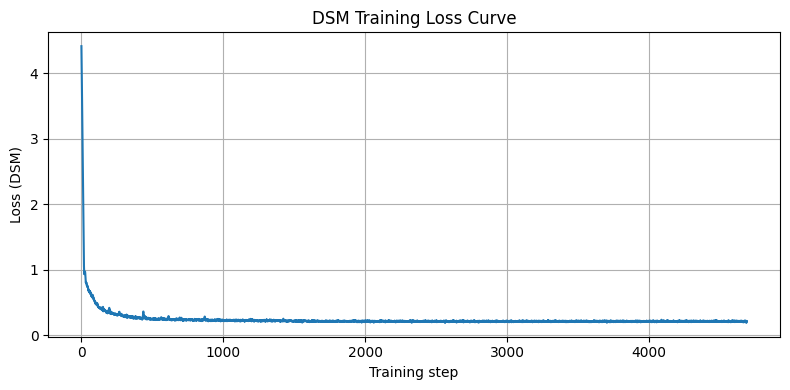

In [22]:
import matplotlib.pyplot as plt
def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

## 2D Langevin Danymics Reverse

In [23]:
def langevin_denoise(model, x, steps=50, eta=0.1):
    x = x.detach().clone()   # 這行最重要：成為 leaf variable

    for _ in range(steps):
        with torch.no_grad():  # 避免建立計算圖
            score = model(x)
            noise = torch.randn_like(x)
            x = x + eta * score + (2*eta)**0.5 * noise

    return x


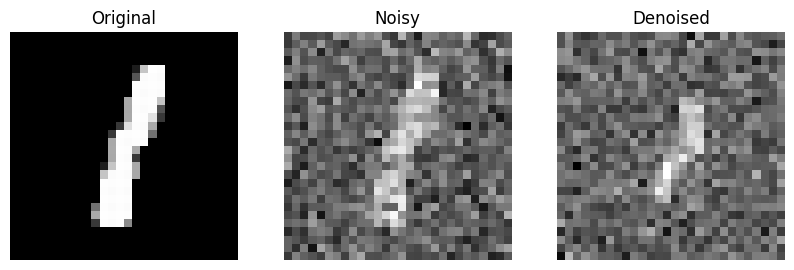

In [29]:
import matplotlib.pyplot as plt

def show_triplet(x0):
    noise = torch.randn_like(x0)
    xT = x0 + 0.7 * noise
    x0p = langevin_denoise(model, xT, steps=1500, eta=0.005)

    imgs = torch.cat([x0, xT, x0p], dim=0).cpu()

    plt.figure(figsize=(10,4))
    titles = ["Original", "Noisy", "Denoised"]

    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(imgs[i,0].detach(), cmap="gray")
        plt.title(titles[i])
        plt.axis("off")

    plt.show()

# 用 batch 中的第一張圖片來測試
for x0, _ in dataloader:
    x0 = x0[:1].to(device)
    show_triplet(x0)
    break
